In [1]:
# Required additional libraries
!pip install imutils
!pip install pycocotools
!pip install -U scikit-image==0.16.2 # Get rid of the training warning

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=77c0bde46f9e671ee489be02d096fb1927d8b97e54d9033c97603158b3270113
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272453 sha256=70bf7baa66709a44b824ebd59351f7dfafd51697e96b5795c374613cbb50079b
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools
     |████████████████████████████████| 26.5 MB 4.4 MB/s eta 0:00:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.1
    Uninstalling scikit-image-0.18.1:
      Successfully uninstalled scikit-image-0.18.1


In [2]:
# import libs
import os, sys
import json
import imutils
import itertools
import matplotlib
import numpy as np
import skimage.draw
import pandas as pd
from PIL import Image
from skimage.io import imread
import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
import tensorflow as tf

# Hide Python Warnings due version errors
import warnings
warnings.filterwarnings("ignore")

# Library cloning Dataset Import from git

In [3]:
!git clone https://github.com/SuienS/Mask_RCNN.git # M R-CNN TensorFlow 2.x implementation
!git clone https://github.com/rastislavkopal/brain-tumor-segmentation.git # MRI Dataset with Annotated Data


!rm -rf brain-tumor-segmentation/.git/
!rm -rf Mask_RCNN/.git/

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 136.81 MiB | 38.30 MiB/s, done.
Resolving deltas: 100% (577/577), done.
Cloning into 'brain-tumor-segmentation'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (322/322), done.
remote: Total 323 (delta 2), reused 314 (delta 0), pack-reused 0
Receiving objects: 100% (323/323), 5.79 MiB | 31.86 MiB/s, done.
Resolving deltas: 100% (2/2), done.


# M R-CNN import

In [4]:
ROOT_DIR = os.path.abspath("./Mask_RCNN") # Imported Library

sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Graphs stored within the notebook
%matplotlib inline

In [5]:
# Paths for log saving and model saving
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = 'logs' 

In [6]:
# Pre-trained weights for M R-CNN on COCO
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download weights if not already available
if not os.path.exists(COCO_MODEL_PATH):
    print('Downloaing weights...')
    utils.download_trained_weights(COCO_MODEL_PATH)

# Import COCO config  
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

Downloaing weights...
... done downloading pretrained model!


# Dataset Specifications and Samples

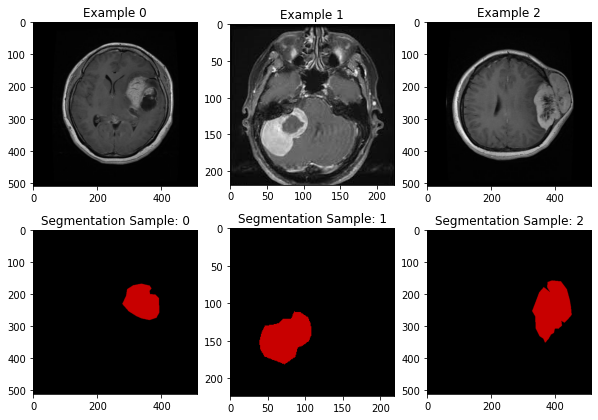

In [7]:
DATASET_DIR = './brain-tumor-segmentation/brain_tumor_data/'

examples = [Image.open(DATASET_DIR + 'train/100.jpg'),Image.open(DATASET_DIR + 'train/116.jpg'),Image.open(DATASET_DIR+'train/221.jpg')]
examplesSeg = ['100.jpg20477','116.jpg10596','221.jpg19584']

# Plot appearance
plt.rcParams['figure.facecolor'] = 'white'
# Sample data from training spit
fig = plt.figure(figsize=(10,14))

for i in range(0, len(examples)):
    a = fig.add_subplot(1, 3, i+1)
    imgplot = plt.imshow(examples[i])
    a.set_title('Example '+str(i))

# Samples from annotations file
with open(DATASET_DIR+'train/annotations.json') as json_file:
    data = json.load(json_file)
    for i in range(0,len(examplesSeg)):
        # load regions from json file and transform them into (x,y) coordinates
        coord = list(zip(data[examplesSeg[i]]['regions'][0]['shape_attributes']['all_points_x'],
                         data[examplesSeg[i]]['regions'][0]['shape_attributes']['all_points_y'])) 
        image = Image.new("RGB", np.asarray(examples[i]).shape[0:2])
        draw = ImageDraw.Draw(image)
        draw.polygon((coord), fill=200)
        a = fig.add_subplot(2, 3, 3+i+1)
        imgplot = plt.imshow(image)
        a.set_title('Segmentation Sample: ' + str(i))

# Dataset Statistics

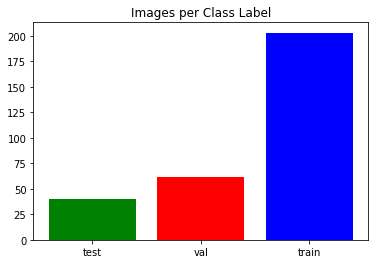

In [8]:
values = dict()
for file in os.listdir(DATASET_DIR):
    values[str(file)] = len(os.listdir('./brain-tumor-segmentation/brain_tumor_data/' + file))
plt.title('Images per Class Label')
plt.bar(range(len(values)), list(values.values()), align='center',color=[ 'green','red', 'blue'])
plt.xticks(range(len(values)), list(values.keys()))
plt.show()

# Train Params

In [9]:
class TrainConfig(Config):
    NAME = "tumor_detect"

    # GPU count and image allocation per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 # Due to Hi-Res images

    NUM_CLASSES = 2 # = Background Class + Tumor Class

    DETECTION_MIN_CONFIDENCE = 0.7 # Threshold value

    # Hyperparams.
    LEARNING_RATE = 0.001 # Initial Learning rate
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5
    
EPOCHS = 18

In [10]:
config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Dataset preparation
* Source: https://www.kdnuggets.com/2020/03/brain-tumor-detection-mask-r-cnn.html

In [11]:
class TumorDataset(utils.Dataset):
    def load_brain_tumor_images(self, dataset_dir, folder):
        self.add_class("tumor", 1, "tumor")
        
        assert folder in ["train", "val", 'test']
        
        dataset_dir = os.path.join(dataset_dir,folder)
        
        annotations = json.load(open(os.path.join(dataset_dir,'annotations.json')))
        
        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]
        
        for i in annotations:
            polygons = [r['shape_attributes'] for r in i['regions']] # Retrieving Annotated regions from JSON
            
            image_path = os.path.join(dataset_dir, i['filename']) # Loading correspending image
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            # Unique file name for all tumor images
            self.add_image('tumor', image_id=i['filename'], width=width, height=height, path=image_path, polygons=polygons)

            
    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # Force Convert to RGB if grayscale.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image
    
    def load_mask(self, image_id):
        # If not a tumor dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count] 
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])],dtype=np.uint8)
        for i, p in enumerate(image_info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Mask and array of class IDs for each instance.
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [12]:
# Train dataset generator
dataset_train = TumorDataset()
dataset_train.load_brain_tumor_images(DATASET_DIR,'train')
dataset_train.prepare()

# Validation dataset generator
dataset_val = TumorDataset()
dataset_val.load_brain_tumor_images(DATASET_DIR,'val')
dataset_val.prepare()

# Test dataset generator
dataset_test = TumorDataset()
dataset_test.load_brain_tumor_images(DATASET_DIR,'test')
dataset_test.prepare()

# Model Compilation

In [13]:
# Training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Pre-loading with coco
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", # excluding wieghts from layers with different dimentions
                                "mrcnn_bbox_fc", 
                                "mrcnn_bbox",
                                "mrcnn_mask"])

# model.load_weights(model.find_last(), by_name=True) # <= to continue training

In [14]:
# Training ONLY the 'heads' layers; weigths excluded layers
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=EPOCHS, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /kaggle/working/Mask_RCNN/logs/tumor_detect20210607T1535/mask_rcnn_tumor_detect_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn

# Inference Mode Setup

In [15]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Inference Mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [16]:
# Loading the last saved weights
model_path = model.find_last()
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/Mask_RCNN/logs/tumor_detect20210607T1535/mask_rcnn_tumor_detect_0018.h5
Re-starting from epoch 18


In [17]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Input Image')
    plt.show()

In [18]:
def get_ax(rows=1, cols=1, size=7):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [19]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, img_id)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)

# Sample Results

## On Validation set

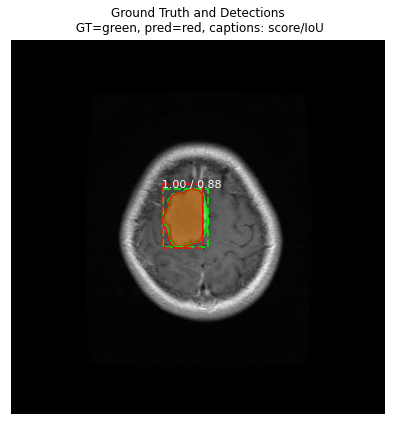

In [20]:
config.USE_MINI_MASK = False # Disables Masks size reduction: Overcomes the error [Temp Fix for Lib error]

predict_and_plot_differences(dataset_val, 0)

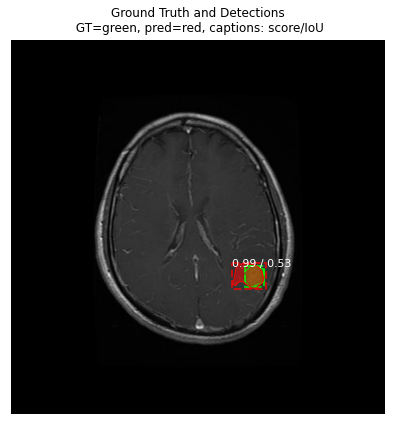

In [21]:
predict_and_plot_differences(dataset_val, 1)

## On Test set

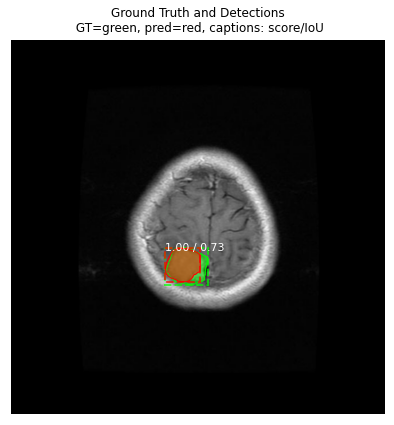

In [22]:
predict_and_plot_differences(dataset_test, 0)

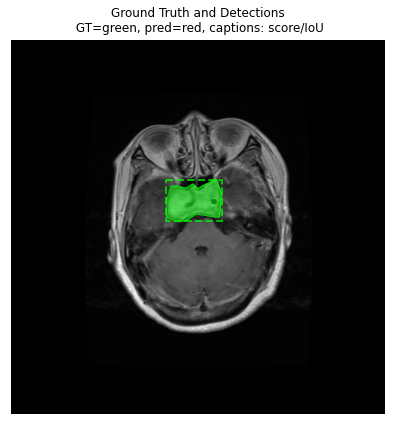

In [23]:
predict_and_plot_differences(dataset_test, 1)

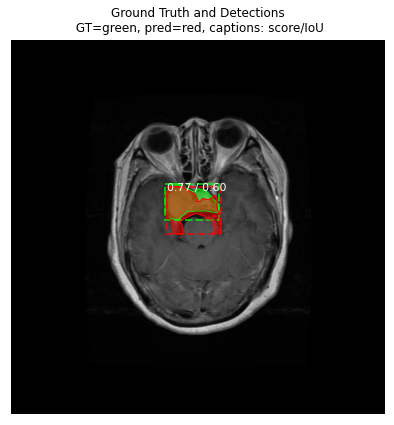

In [24]:
predict_and_plot_differences(dataset_test, 2)

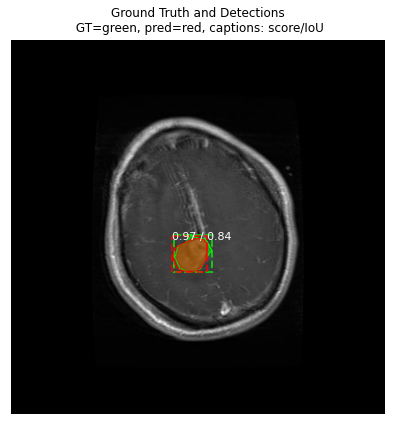

In [25]:
predict_and_plot_differences(dataset_test, 3)

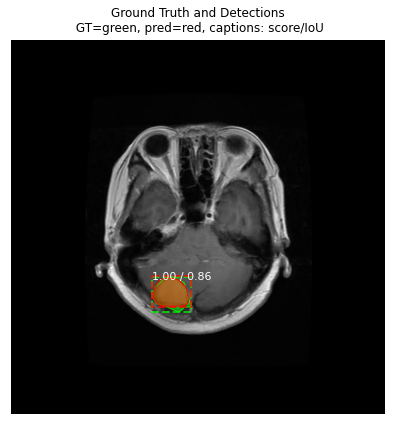

In [26]:
predict_and_plot_differences(dataset_test, 4)

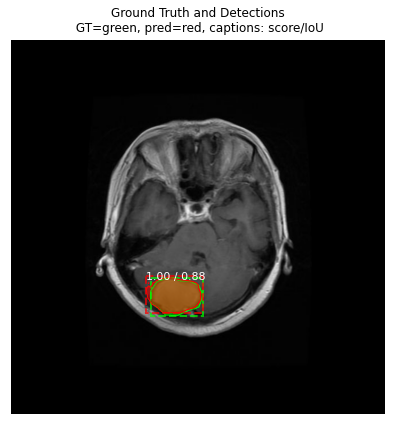

In [27]:
predict_and_plot_differences(dataset_test, 5)

config.USE_MINI_MASK = True # Renables Masks size reduction => Helps training

# References
* https://github.com/matterport/Mask_RCNN
* https://github.com/leekunhee/Mask_RCNN
* https://www.kdnuggets.com/2020/03/brain-tumor-detection-mask-r-cnn.html